# Distances histogram

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import matplotlib.pyplot as plt; plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import matplotlib as mpl
import pandas as pd
import librosa
import numpy as np
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import tqdm
import itertools
import scipy.stats, scipy.spatial
import random

import identification.dataset

In [33]:
config = {
    'frame_size': 2048,
    'hop_ratio': 1,
    'n_mels': 100,
    'n_coeff': 60,
    'sr': 10000,
    'sample_duration': 30,
    'feature': 'scattering',
    'clf': sklearn.svm.SVC(),
    'clf__decision_functioSn_shape': 'ovr',
    'clf__kernel': 'linear',
    'clf__C': 1.0,
}

data = pd.read_pickle('../data/processed/dataset_bilbao.pkl')
data = data[data.type.isin(['scale']) & (data.player != 15)]
data = data[(data.player.isin([1,2,3,4]))]

# data = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
# data = data[(data.violin.isin(['A', 'B', 'C']))]

features = identification.dataset.get_dataset(config, data)

100%|██████████| 51/51 [00:34<00:00,  1.46it/s]


In [27]:
X = np.vstack(features.features)
y = features.violin.to_numpy()

estimator = config['clf']
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.MaxAbsScaler()),
    ('clf', estimator),
])
valid_params = pipeline.get_params()
params = {x:config[x] for x in config if x in valid_params}
pipeline.set_params(**params)
pipeline.fit(X, y)
print(pipeline.score(X, y))

0.7843137254901961


In [28]:
a = np.vstack(features.features)

b = scipy.spatial.distance.cdist(a, a, 'euclidean')
all_distances = b[np.triu_indices(len(b), k=1)]

def group_distances(features, column):
    values = features[column].unique()

    distances = []
    for value in values:
        points = features[features[column] == value]
        a = np.vstack(points.features)
        b = scipy.spatial.distance.cdist(a, a, 'euclidean')
        distances.append(b[np.triu_indices(len(b), k=1)])

    return np.hstack(distances)

intra_violin_distances = group_distances(features, 'violin')
intra_player_distances = group_distances(features, 'player')


In [30]:
results = []
for i in range(config['n_coeff']):
    def group_distances(features, column):
        values = features[column].unique()

        distances = []
        for value in values:
            points = features[features[column] == value]
            a = np.vstack(points.features)[:, i:i+1]
            b = scipy.spatial.distance.cdist(a, a, 'euclidean')
            distances.append(b[np.triu_indices(len(b), k=1)])

        return np.hstack(distances)

    intra_violin_distances = group_distances(features, 'violin')
    intra_player_distances = group_distances(features, 'player')
    results.append([intra_violin_distances.mean(), intra_player_distances.mean()])

results = np.vstack(results)
diff = results[:, 1] - results[:, 0]
idx = np.argsort(diff)
print(diff[idx])
print(idx)

[-0.14743414 -0.14376396 -0.12996165 -0.12732445 -0.1259819  -0.12335821
 -0.12298338 -0.11278352 -0.11139385 -0.1110055  -0.1051999  -0.10430085
 -0.09746954 -0.0913471  -0.09106605 -0.08729228 -0.08706267 -0.08279126
 -0.08137294 -0.08112186 -0.07315542 -0.06987995 -0.06965115 -0.0684043
 -0.06719258 -0.06611431 -0.06546886 -0.06436957 -0.06365779 -0.06345486
 -0.05996615 -0.05809378 -0.05752166 -0.05688818 -0.0563057  -0.05628866
 -0.05312159 -0.05055905 -0.04995513 -0.04916628 -0.04787472 -0.0446931
 -0.04388124 -0.04178503 -0.03977578 -0.03625234 -0.03580328 -0.02916854
 -0.0270849  -0.02464109 -0.0146486  -0.01036656 -0.00941303 -0.00884476
 -0.00584619 -0.0043033  -0.00037779 -0.0002665   0.00658783  0.00749958]
[33 41 48 40 32 49 14 34 42  0 47 50 51 43 35 39 58 59 15  6 19 55 31 16
 54 52 20 38 57 56 36  3 24 17 46 30  1 23  2 22 18 25 44 28  5 53 29  9
  4 21 37  8 26  7 11 12 10 27 45 13]


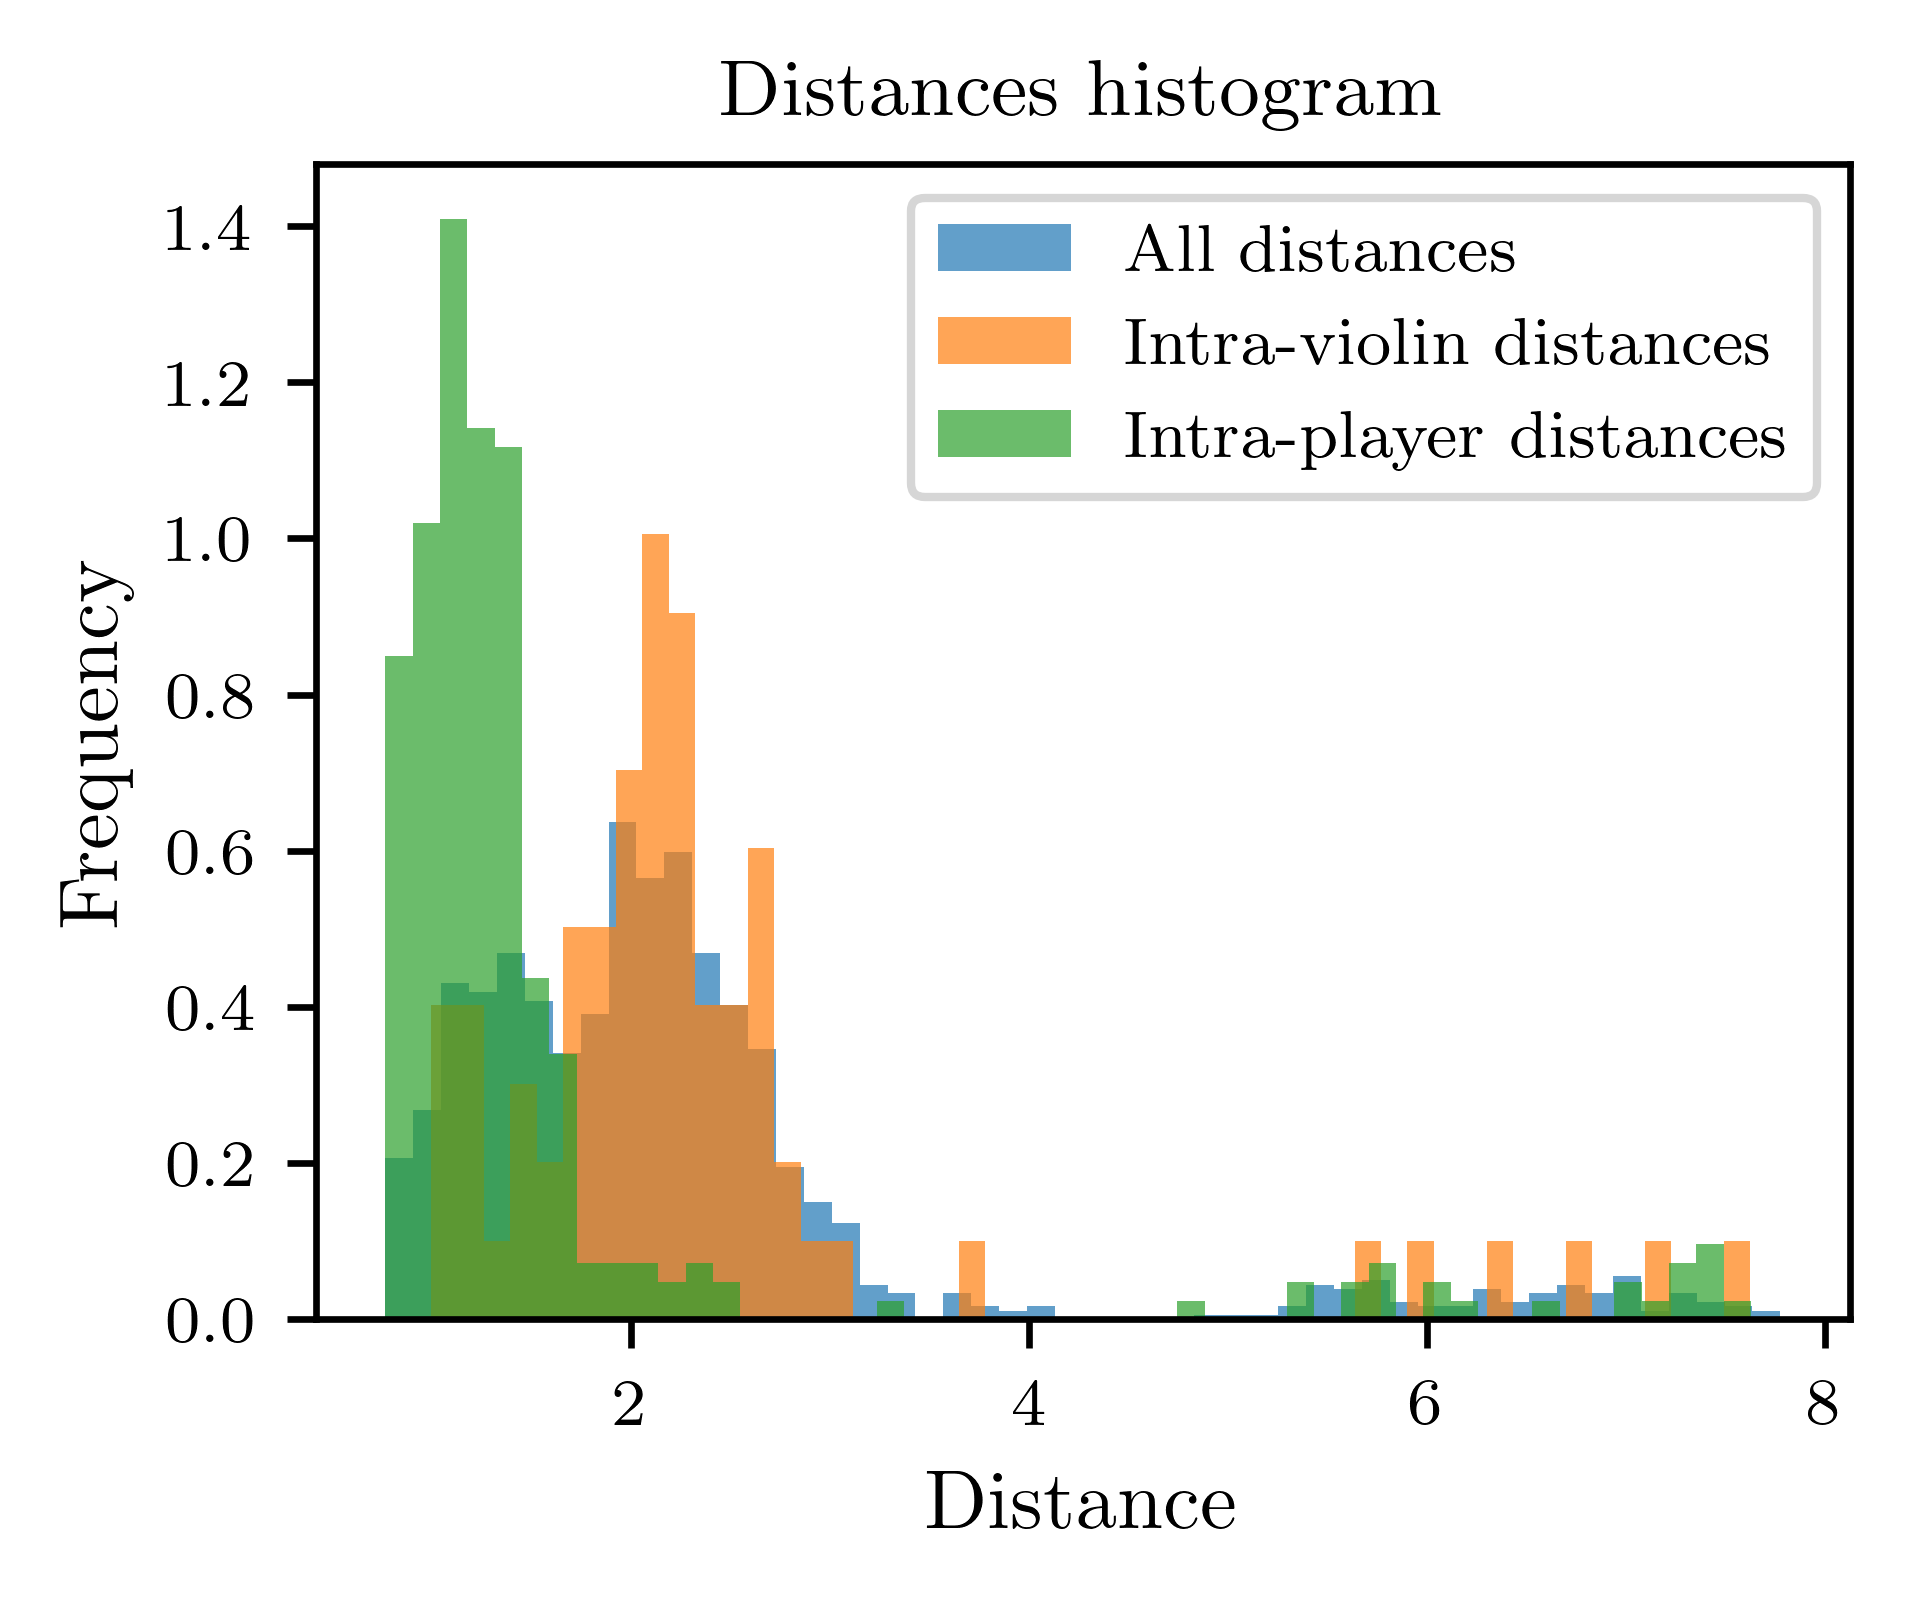

In [29]:
fig, ax = plt.subplots()
ax.hist(all_distances, bins=50, density=True, label='All distances', alpha=.7)
ax.hist(intra_violin_distances, bins=50, density=True, label='Intra-violin distances', alpha=.7)
ax.hist(intra_player_distances, bins=50, density=True, label='Intra-player distances', alpha=.7)
ax.set_title('Distances histogram')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()